<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/notebooks/00_WhiteNoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 백색잡음(white noise)

White noise: n=1000, sample mean=-0.0289, sample var=0.9786


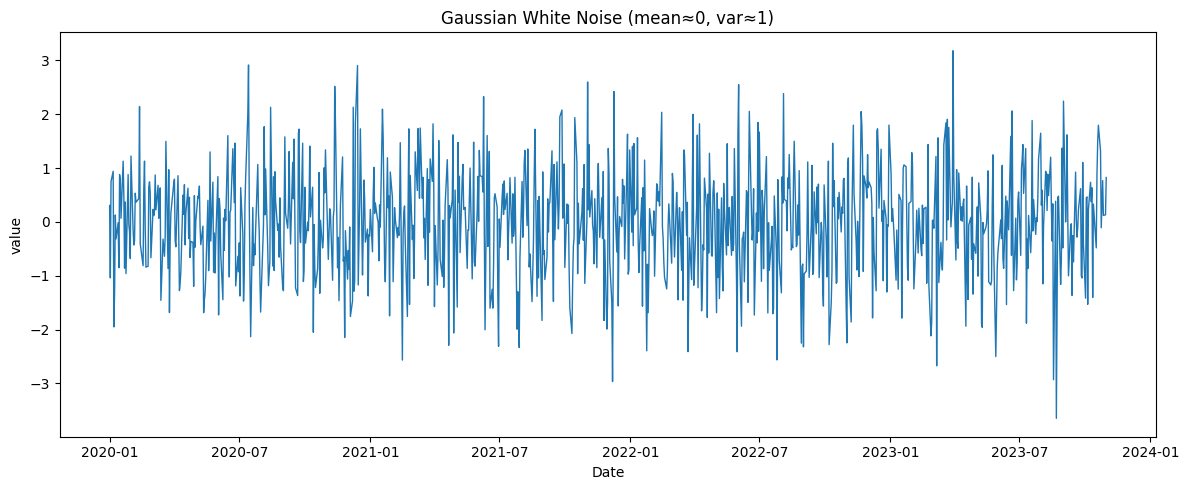

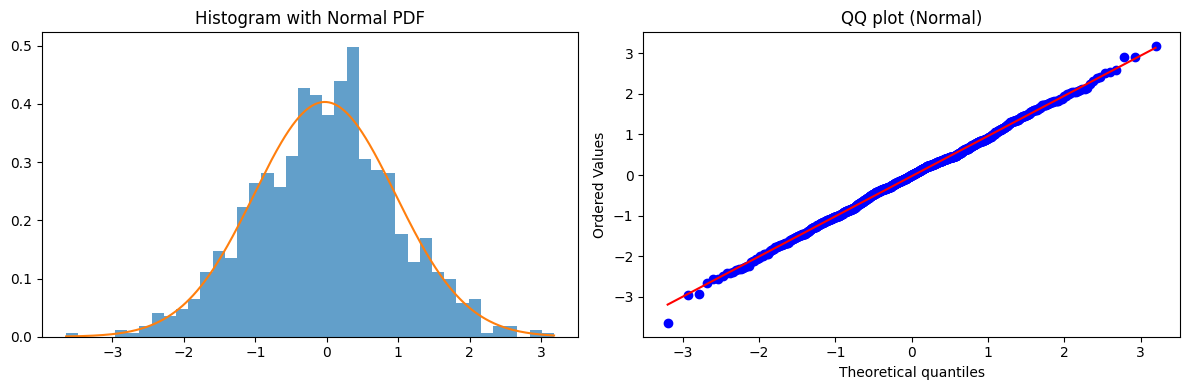

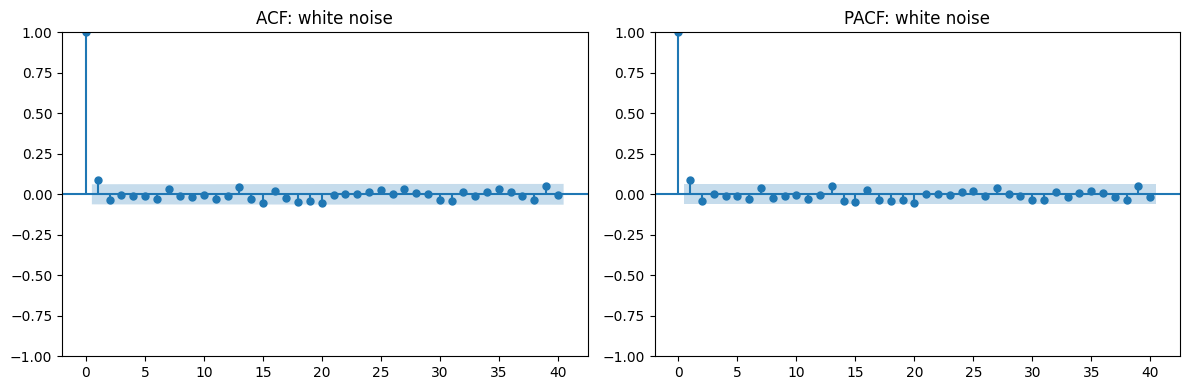


[Ljung–Box] white noise
     LB stat  p-value
lag                  
10   11.3872   0.3282
20   26.6883   0.1443
40   38.0066   0.5603
  lag=10 → p=0.3282 → Fail to reject H0 (no autocorr)
  lag=20 → p=0.1443 → Fail to reject H0 (no autocorr)
  lag=40 → p=0.5603 → Fail to reject H0 (no autocorr)


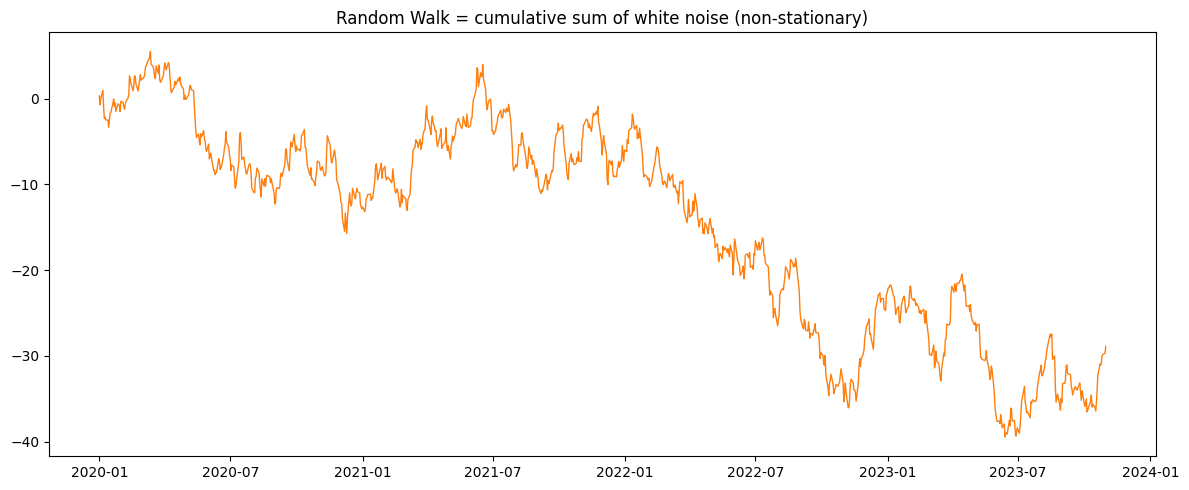

[*********************100%***********************]  1 of 1 completed



TSLA: 2018-01-02 ~ 2025-10-08 | 1953 prices, 1952 returns


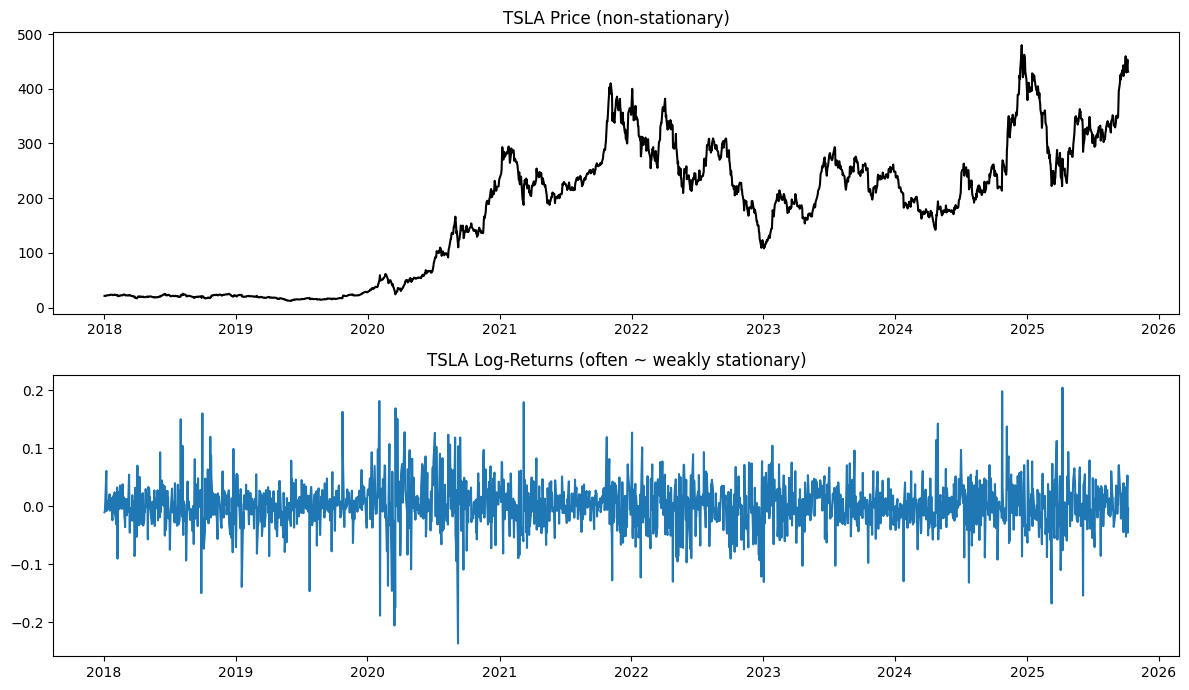

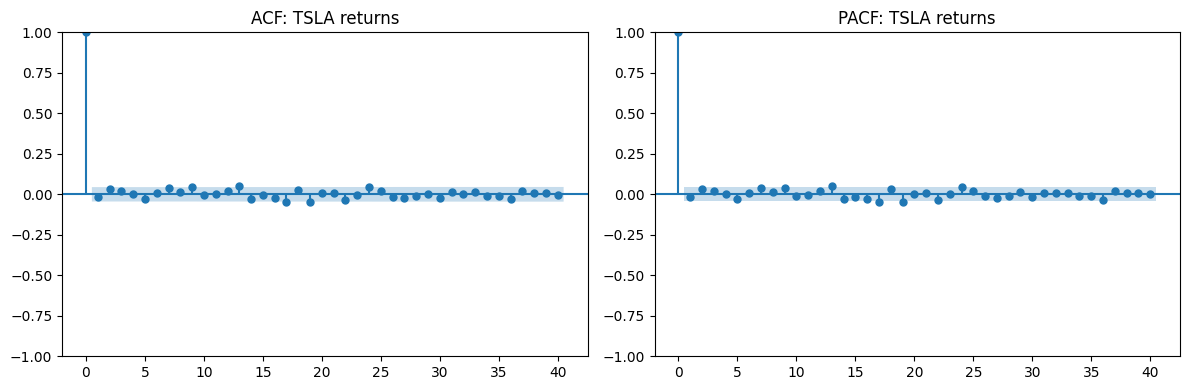


[Ljung–Box] TSLA log-returns
     LB stat  p-value
lag                  
10   11.5179   0.3186
20   31.9102   0.0443
40   45.9229   0.2401
  lag=10 → p=0.3186 → Fail to reject H0 (no autocorr)
  lag=20 → p=0.0443 → Reject H0 (autocorr exists)
  lag=40 → p=0.2401 → Fail to reject H0 (no autocorr)


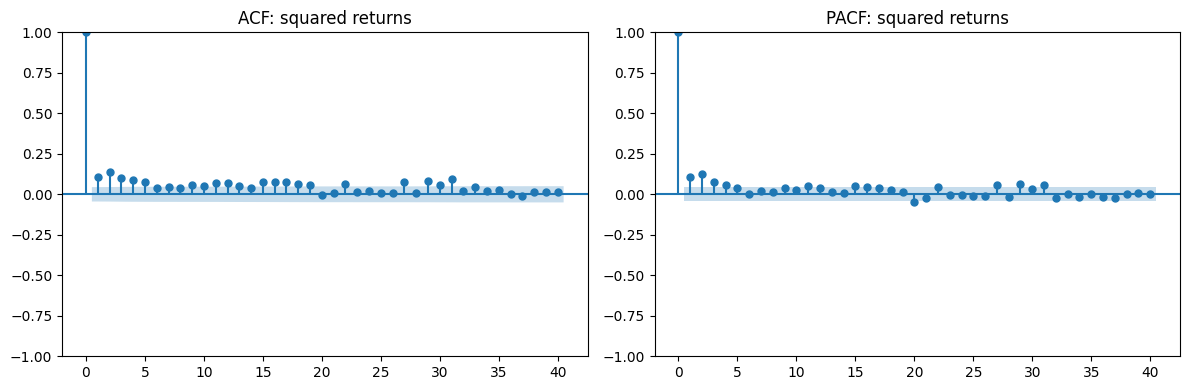


[Ljung–Box] (TSLA returns)^2
     LB stat  p-value
lag                  
10  125.1597   0.0000
20  202.1468   0.0000
40  270.5743   0.0000
  lag=10 → p=0.0000 → Reject H0 (autocorr exists)
  lag=20 → p=0.0000 → Reject H0 (autocorr exists)
  lag=40 → p=0.0000 → Reject H0 (autocorr exists)


,LB stat,p-value
lag,,
10,125.159713,4.525206e-22
20,202.146797,4.230600e-32
40,270.574325,5.241303e-36


In [4]:
# =========================================================
# White Noise demo + (reference) TSLA log-returns  (fixed)
# =========================================================
# %pip -q install yfinance statsmodels scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats

plt.rcParams["figure.figsize"] = (12, 5)

# ----------------------------------
# 0) Helper: Ljung–Box reporting
# ----------------------------------
def lb_report(x, lags=(10, 20, 40), alpha=0.05, name="series"):
    x = pd.Series(x).dropna()
    out = acorr_ljungbox(x, lags=list(lags), return_df=True)
    res = out[["lb_stat", "lb_pvalue"]].rename(columns={"lb_stat":"LB stat", "lb_pvalue":"p-value"})
    res.index.name = "lag"
    print(f"\n[Ljung–Box] {name}")
    print(res.to_string(float_format=lambda v: f"{v:,.4f}"))
    for lag, p in zip(res.index, res["p-value"]):
        decision = "Fail to reject H0 (no autocorr)" if p >= alpha else "Reject H0 (autocorr exists)"
        print(f"  lag={lag:>2} → p={p:.4f} → {decision}")
    return res

# =========================================================
# 1) Simulated WHITE NOISE  (Gaussian white noise)
# =========================================================
rng = np.random.default_rng(42)
n = 1_000
sigma = 1.0

eps = rng.normal(loc=0.0, scale=sigma, size=n)
idx  = pd.date_range("2020-01-01", periods=n, freq="B")
wn   = pd.Series(eps, index=idx, name="white_noise")

print(f"White noise: n={len(wn)}, sample mean={wn.mean():.4f}, sample var={wn.var(ddof=1):.4f}")

# --- Time series plot
plt.figure()
plt.plot(wn.index, wn.values, lw=1)
plt.title("Gaussian White Noise (mean≈0, var≈1)")
plt.xlabel("Date"); plt.ylabel("value"); plt.tight_layout(); plt.show()

# --- Histogram + normal fit + QQ plot
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(wn, bins=40, density=True, alpha=0.7)
xgrid = np.linspace(wn.min(), wn.max(), 400)
ax[0].plot(xgrid, stats.norm.pdf(xgrid, wn.mean(), wn.std(ddof=1)))
ax[0].set_title("Histogram with Normal PDF")

stats.probplot(wn, dist="norm", plot=ax[1])
ax[1].set_title("QQ plot (Normal)")
plt.tight_layout(); plt.show()

# --- ACF / PACF
fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_acf(wn, lags=40, ax=ax[0]); ax[0].set_title("ACF: white noise")
plot_pacf(wn, lags=40, ax=ax[1], method="ywm"); ax[1].set_title("PACF: white noise")
plt.tight_layout(); plt.show()

# --- Ljung–Box (should NOT reject H0 for true white noise)
lb_report(wn, lags=(10, 20, 40), name="white noise")

# (참고) 누적합은 '랜덤워크' → 비정상
rw = wn.cumsum()
plt.figure()
plt.plot(rw, lw=1, color="tab:orange")
plt.title("Random Walk = cumulative sum of white noise (non-stationary)")
plt.tight_layout(); plt.show()

# =========================================================
# 2) Reference: TSLA daily LOG-RETURNS (approx white noise?)
# =========================================================
symbol = "TSLA"
px = yf.download(symbol, start="2018-01-01", auto_adjust=True)[["Close"]].dropna()
px.index = pd.to_datetime(px.index)

# 반드시 Series로 만들고 이름 지정
price = px.squeeze("columns").astype(float)
price.name = "price"

# rename(...) 쓰지 말고 name 속성으로 지정
ret = np.log(price).diff().dropna()
ret.name = "log_return"

print(f"\nTSLA: {price.index[0].date()} ~ {price.index[-1].date()} | "
      f"{len(price)} prices, {len(ret)} returns")

# --- Time series (price vs returns)
fig, ax = plt.subplots(2, 1, figsize=(12,7), sharex=False)
ax[0].plot(price, color="black"); ax[0].set_title("TSLA Price (non-stationary)")
ax[1].plot(ret, color="tab:blue"); ax[1].set_title("TSLA Log-Returns (often ~ weakly stationary)")
plt.tight_layout(); plt.show()

# --- ACF/PACF of returns
fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_acf(ret, lags=40, ax=ax[0]); ax[0].set_title("ACF: TSLA returns")
plot_pacf(ret, lags=40, ax=ax[1], method="ywm"); ax[1].set_title("PACF: TSLA returns")
plt.tight_layout(); plt.show()

# --- Ljung–Box on returns
lb_report(ret, lags=(10, 20, 40), name="TSLA log-returns")

# --- (Optional) squared returns: volatility clustering check
fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_acf(ret**2, lags=40, ax=ax[0]); ax[0].set_title("ACF: squared returns")
plot_pacf(ret**2, lags=40, ax=ax[1], method="ywm"); ax[1].set_title("PACF: squared returns")
plt.tight_layout(); plt.show()

lb_report(ret**2, lags=(10, 20, 40), name="(TSLA returns)^2")


# 확률보행(Random Walk)

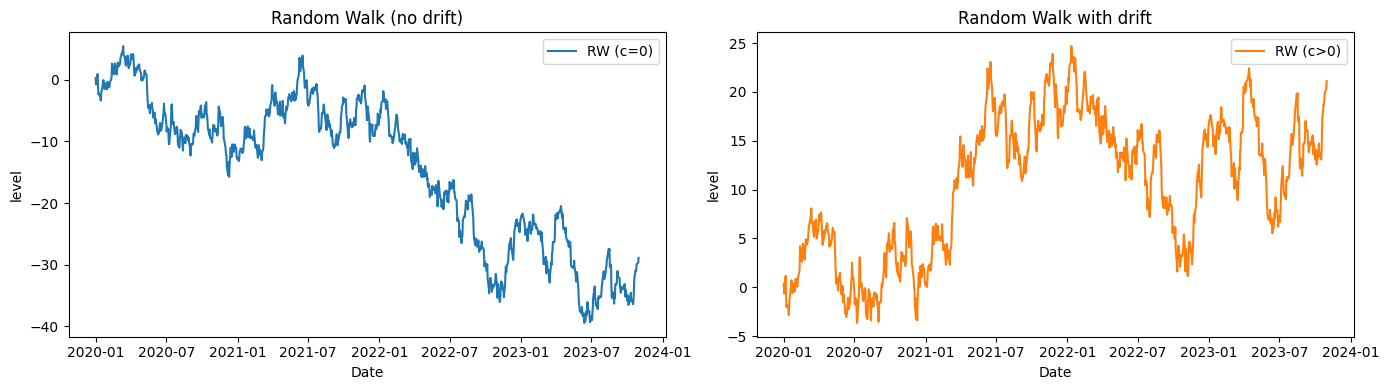

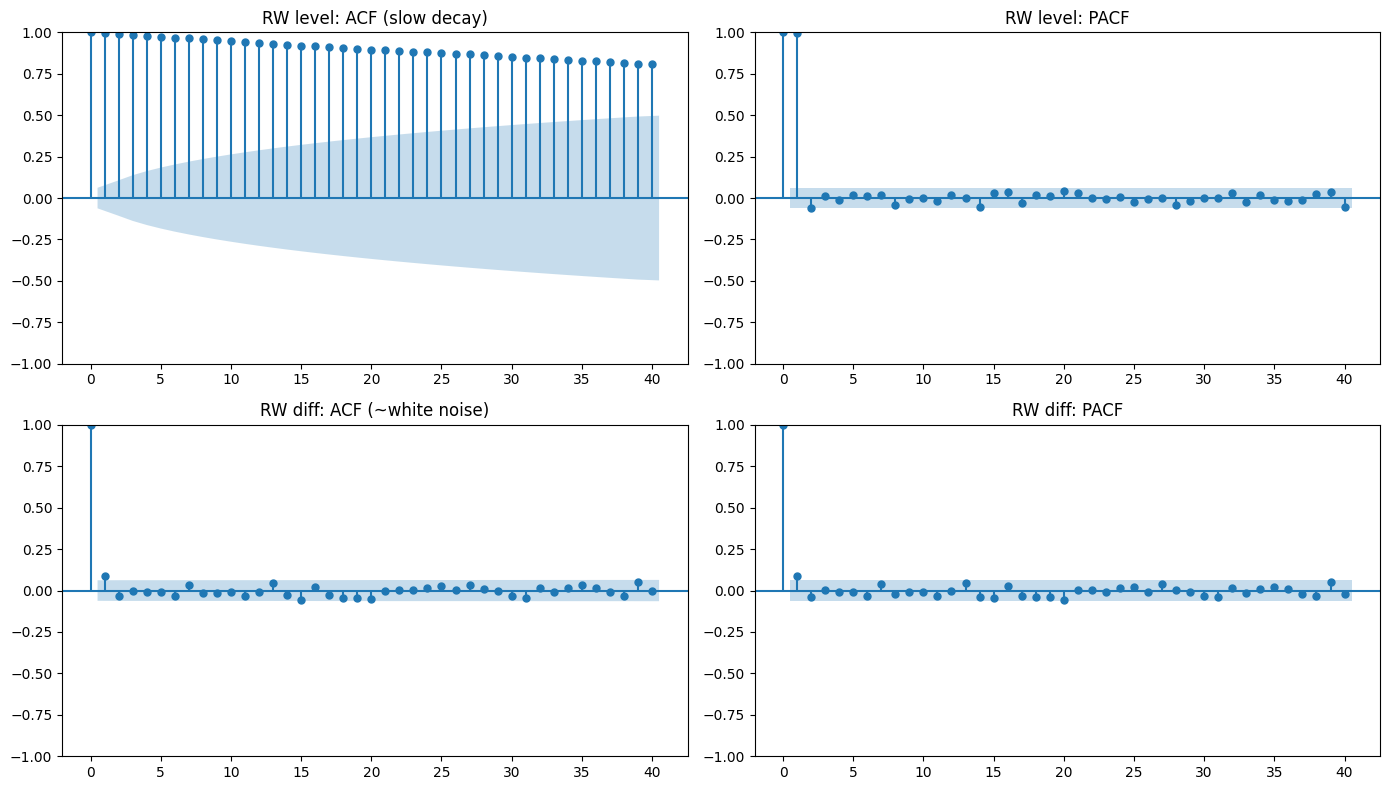


[Stationarity tests] RW level
  ADF p=0.5787  → p<0.05 ⇒ stationarity (reject unit root)
  KPSS p=0.0100 → p>0.05 ⇒ stationarity (fail to reject)

[Stationarity tests] RW first difference
  ADF p=0.0000  → p<0.05 ⇒ stationarity (reject unit root)
  KPSS p=0.1000 → p>0.05 ⇒ stationarity (fail to reject)

[Ljung–Box] RW level  (H0: no autocorrelation)
  lag=10  p=0.0000  → Significant (reject H0)
  lag=20  p=0.0000  → Significant (reject H0)
  lag=40  p=0.0000  → Significant (reject H0)

[Ljung–Box] RW first difference  (H0: no autocorrelation)
  lag=10  p=0.3241  → Not significant (fail to reject H0)
  lag=20  p=0.1442  → Not significant (fail to reject H0)
  lag=40  p=0.5626  → Not significant (fail to reject H0)

TSLA: 2018-01-02 ~ 2025-10-08 | 1953 prices, 1952 returns


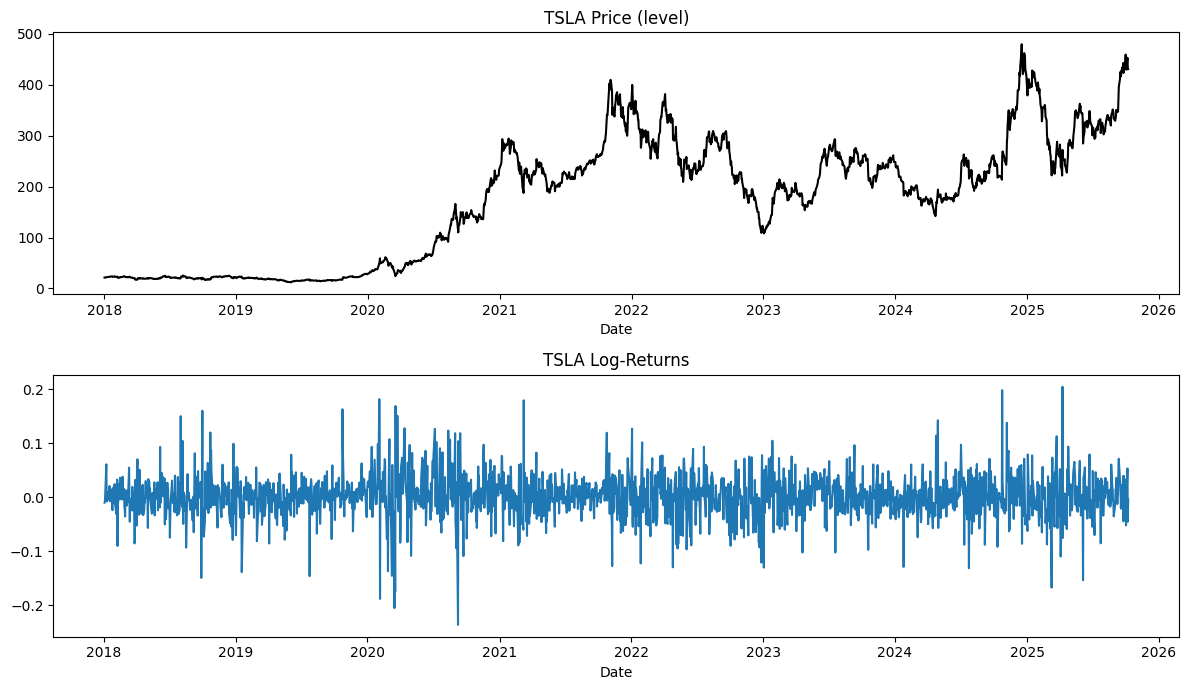

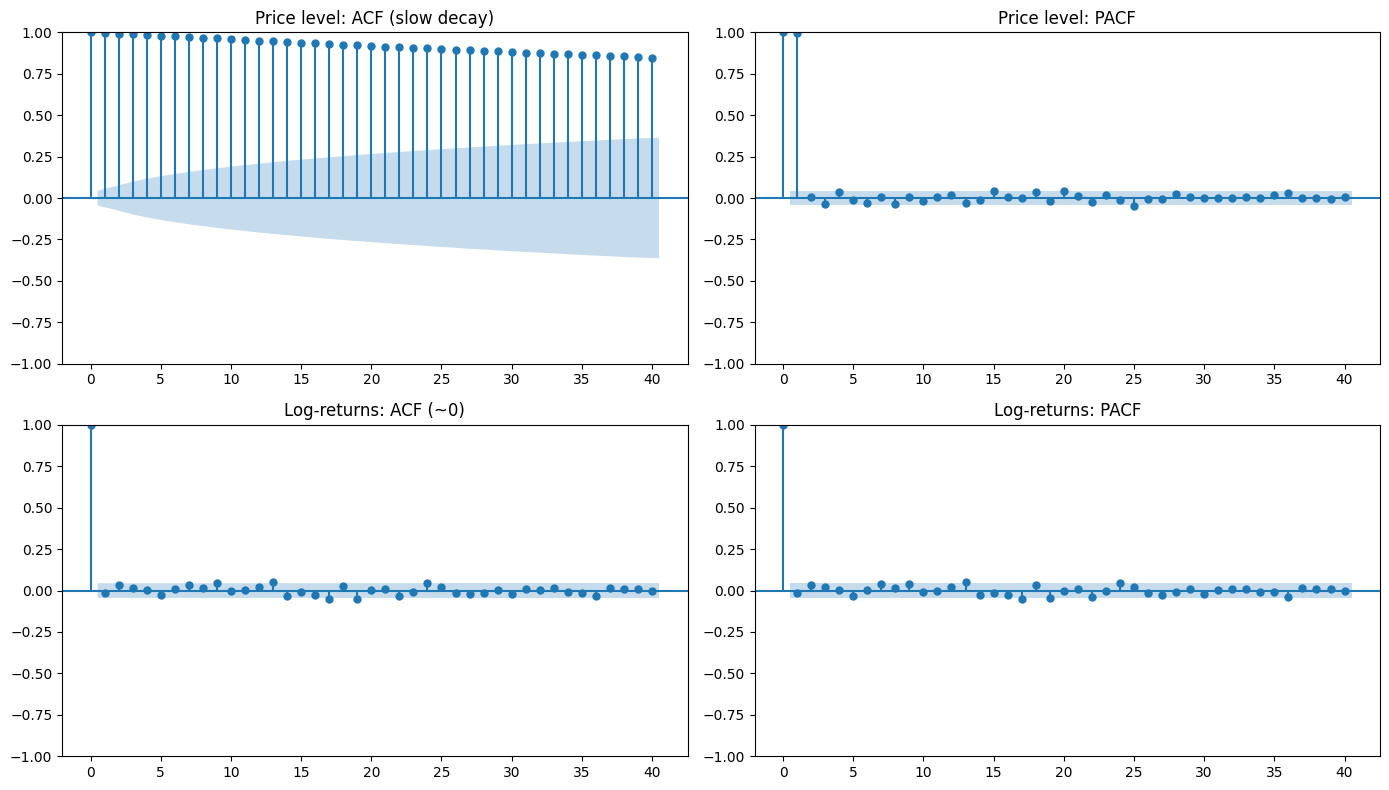


[Stationarity tests] TSLA price (level)
  ADF p=0.6038  → p<0.05 ⇒ stationarity (reject unit root)
  KPSS p=0.0100 → p>0.05 ⇒ stationarity (fail to reject)

[Stationarity tests] TSLA log-returns
  ADF p=0.0000  → p<0.05 ⇒ stationarity (reject unit root)
  KPSS p=0.1000 → p>0.05 ⇒ stationarity (fail to reject)

[Ljung–Box] TSLA price (level)  (H0: no autocorrelation)
  lag=10  p=0.0000  → Significant (reject H0)
  lag=20  p=0.0000  → Significant (reject H0)
  lag=40  p=0.0000  → Significant (reject H0)

[Ljung–Box] TSLA log-returns  (H0: no autocorrelation)
  lag=10  p=0.3186  → Not significant (fail to reject H0)
  lag=20  p=0.0443  → Significant (reject H0)
  lag=40  p=0.2402  → Not significant (fail to reject H0)


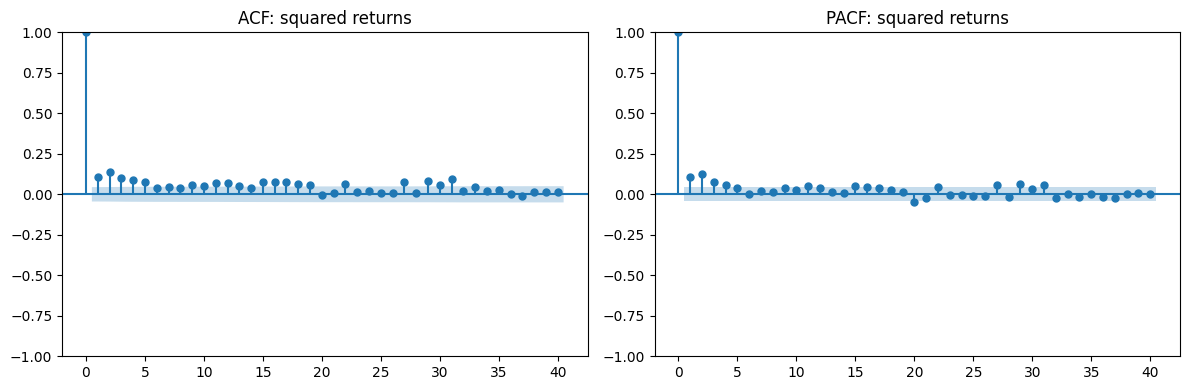


[Ljung–Box] (TSLA returns)^2  (H0: no autocorrelation)
  lag=10  p=0.0000  → Significant (reject H0)
  lag=20  p=0.0000  → Significant (reject H0)
  lag=40  p=0.0000  → Significant (reject H0)


,lb_stat,lb_pvalue
10,125.159879,4.524854e-22
20,202.146922,4.230359e-32
40,270.573997,5.242042e-36


In [6]:
# =========================================================
# Random Walk demo (with TSLA comparison)
# =========================================================
# %pip -q install yfinance statsmodels scipy

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox

plt.rcParams["figure.figsize"] = (12, 5)

# -----------------------------
# Helper: tests & printouts
# -----------------------------
def adf_kpss_report(x, name="series"):
    s = pd.Series(x).dropna()
    adf_p  = adfuller(s, autolag="AIC")[1]
    kpss_p = kpss(s, regression="c", nlags="auto")[1]
    print(f"\n[Stationarity tests] {name}")
    print(f"  ADF p={adf_p:.4f}  → p<0.05 ⇒ stationarity (reject unit root)")
    print(f"  KPSS p={kpss_p:.4f} → p>0.05 ⇒ stationarity (fail to reject)")
    return adf_p, kpss_p

def lb_report(x, lags=(10, 20, 40), alpha=0.05, name="series"):
    s = pd.Series(x).dropna()
    out = acorr_ljungbox(s, lags=list(lags), return_df=True)
    print(f"\n[Ljung–Box] {name}  (H0: no autocorrelation)")
    for L in out.index:
        p = float(out.loc[L, "lb_pvalue"])
        decision = "Not significant (fail to reject H0)" if p >= alpha else "Significant (reject H0)"
        print(f"  lag={L:>2}  p={p:.4f}  → {decision}")
    return out

# -----------------------------
# 1) Simulated Random Walks
# -----------------------------
def make_random_walk(n=1000, drift=0.0, sigma=1.0, seed=42):
    rng = np.random.default_rng(seed)
    eps = rng.normal(0.0, sigma, n)
    y = np.cumsum(drift + eps)      # y_t = y_{t-1} + c + eps_t
    idx = pd.date_range("2020-01-01", periods=n, freq="B")
    return pd.Series(y, index=idx, name=f"RW_drift_{drift}")

rw0  = make_random_walk(drift=0.0)     # pure RW
rw_c = make_random_walk(drift=0.05)    # RW with drift

fig, ax = plt.subplots(1, 2, figsize=(14,4))
ax[0].plot(rw0, label="RW (c=0)", color="tab:blue")
ax[0].set_title("Random Walk (no drift)")
ax[1].plot(rw_c, label="RW (c>0)", color="tab:orange")
ax[1].set_title("Random Walk with drift")
for a in ax: a.legend(); a.set_xlabel("Date"); a.set_ylabel("level")
plt.tight_layout(); plt.show()

# ACF/PACF of random walk (levels) vs 1st-difference
fig, ax = plt.subplots(2, 2, figsize=(14,8))
plot_acf(rw0,   lags=40, ax=ax[0,0]); ax[0,0].set_title("RW level: ACF (slow decay)")
plot_pacf(rw0,  lags=40, ax=ax[0,1], method="ywm"); ax[0,1].set_title("RW level: PACF")
plot_acf(rw0.diff().dropna(),  lags=40, ax=ax[1,0]); ax[1,0].set_title("RW diff: ACF (~white noise)")
plot_pacf(rw0.diff().dropna(), lags=40, ax=ax[1,1], method="ywm"); ax[1,1].set_title("RW diff: PACF")
plt.tight_layout(); plt.show()

# Tests
adf_kpss_report(rw0, "RW level")
adf_kpss_report(rw0.diff().dropna(), "RW first difference")
lb_report(rw0, lags=(10,20,40), name="RW level")
lb_report(rw0.diff().dropna(), lags=(10,20,40), name="RW first difference")

# -----------------------------
# 2) TSLA price ≈ random walk, returns ≈ white noise?
# -----------------------------
symbol, start = "TSLA", "2018-01-01"
px = yf.download(symbol, start=start, auto_adjust=True, progress=False)
px.index = pd.to_datetime(px.index)

# robust: force a 1-D Series and avoid rename pitfalls
if isinstance(px.columns, pd.MultiIndex):
    # yfinance가 MultiIndex를 줄 때 대비 (단일 종목이어도 생길 수 있음)
    if ('Close', symbol) in px.columns:
        price = px[('Close', symbol)]
    elif ('Adj Close', symbol) in px.columns:
        price = px[('Adj Close', symbol)]
    else:
        # level=0에서 'Close'만 뽑고 첫 컬럼 선택
        price = px.xs('Close', axis=1, level=0).iloc[:, 0]
else:
    if 'Close' in px.columns:
        price = px['Close']
    elif 'Adj Close' in px.columns:
        price = px['Adj Close']
    else:
        price = px.iloc[:, 0]

price = pd.to_numeric(price, errors='coerce').dropna()
price.name = "price"

logp = np.log(price)
ret  = logp.diff().dropna()
ret.name = "log_return"

print(f"\nTSLA: {price.index[0].date()} ~ {price.index[-1].date()} | "
      f"{len(price)} prices, {len(ret)} returns")

fig, ax = plt.subplots(2, 1, figsize=(12,7), sharex=False)
ax[0].plot(price, color="black");     ax[0].set_title("TSLA Price (level)")
ax[1].plot(ret,   color="tab:blue");  ax[1].set_title("TSLA Log-Returns")
for a in ax: a.set_xlabel("Date")
plt.tight_layout(); plt.show()

# ACF/PACF
fig, ax = plt.subplots(2, 2, figsize=(14,8))
plot_acf(price, lags=40, ax=ax[0,0]); ax[0,0].set_title("Price level: ACF (slow decay)")
plot_pacf(price, lags=40, ax=ax[0,1], method="ywm"); ax[0,1].set_title("Price level: PACF")
plot_acf(ret,   lags=40, ax=ax[1,0]); ax[1,0].set_title("Log-returns: ACF (~0)")
plot_pacf(ret,  lags=40, ax=ax[1,1], method="ywm"); ax[1,1].set_title("Log-returns: PACF")
plt.tight_layout(); plt.show()

# Tests on TSLA
adf_kpss_report(price, "TSLA price (level)")
adf_kpss_report(ret,   "TSLA log-returns")

# Ljung–Box: price vs returns (또렷한 대비)
lb_report(price, lags=(10,20,40), name="TSLA price (level)")
lb_report(ret,   lags=(10,20,40), name="TSLA log-returns")

# (참고) squared returns → volatility clustering는 보통 유의
fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_acf(ret**2, lags=40, ax=ax[0]); ax[0].set_title("ACF: squared returns")
plot_pacf(ret**2, lags=40, ax=ax[1], method="ywm"); ax[1].set_title("PACF: squared returns")
plt.tight_layout(); plt.show()
lb_report(ret**2, lags=(10,20,40), name="(TSLA returns)^2")
